In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import scipy.io
import spectral_diffusercam_utils.helper_functions as helper
from diffuser_utils import *
import cv2
# Change this to GPU or CPU depending on your machine
%run fista_spectral_cupy.py CPU

device =  CPU , using CPU and numpy


In [2]:
if device == 'GPU':
    import cupy as np
    np.cuda.Device(0).use() # Use this to set which GPU to use in cupy
else:
    import numpy as np

# Modeling Spectral DiffuserCam + Spectral DefocusCam
This notebook shows the following:
* how to recover hyperspectral image from real/experimental Spectral DiffuserCam measurements
* how to simulate measurements for Spectral DiffuserCam 
* how to simulate meausrements for Spectral DefocusCam
* a simple way of recovering images for Spectral DefocusCam (using FISTA + TV) 

Everything in this notebook is in numpy and cupy (GPU-accelerated numpy). Pytorch is very similar to numpy, so the modeling in numpy vs. pytorch is nearly equivalent when we move over the Pytorch to learn the reconstruction. In this notebook, we use FISTA (an iterative optimization algorithm based on sparsity).

# Spectral DiffuserCam Demo
Here we'll read in real data from the Spectral DiffuserCam and then use FISTA+TV to recover the hyperspectral image from the 2D measurement

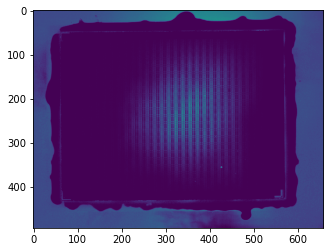

In [3]:
img = plt.imread('../defocuscamdata/sample_data/meas_thordog.png')
plt.imshow(img)

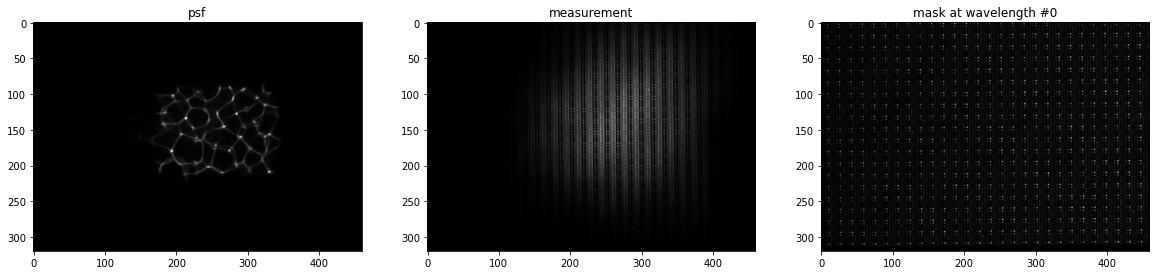

In [4]:
loaded_mat = scipy.io.loadmat('../defocuscamdata/sample_data/calibration.mat')
img = plt.imread('../defocuscamdata/sample_data/meas_thordog.png')
mask, psf, img = helper.preprocess(loaded_mat['mask'], loaded_mat['psf'], img)
mask = mask[:,:,0:-1]

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].imshow(psf, cmap = 'gray')
ax[1].imshow(img, cmap = 'gray')
ax[2].imshow(mask[...,0], cmap = 'gray')

titles = ['psf', 'measurement', 'mask at wavelength #0']
for i in range(0,3):
    ax[i].set_title(titles[i])

In [5]:
print('size of psf:', psf.shape)
print('size of measurement:', img.shape)
print('size of mask: ', mask.shape)

size of psf: (320, 460)
size of measurement: (320, 460)
size of mask:  (320, 460, 64)


Notice that the point spread function (PSF) and the measurement are 2D images, while the mask is a 3D object with $xy\lambda$. The $\lambda$ dimension has 64 channels. Each of these correspond to the responce of the spectral filters at a different wavelength. Note that the spectral filters are not perfectly aligned with the sensor pixels, so we have to have this calibration matrix to understand the response of the sensor to different wavelengths (we can't just say: I know that pixel #3 corresponds to 620nm and pixel #5 corresponds to 440nm, since each filter may cover multiple pixels, and a single pixel may have parts of two or more filters over it due to this misalignment).

This matrix, 'mask', was obtained by taking our sensor+filter and shining light from a monochrometer on it. We set the monochrometer to have a bandwidth of ~5nm, and then scanned across wavelenghts. The following array (wavs) has the conversion between the mask indices and the corresponding center wavelength that the monochrometer was set to for the measurement. 

In [6]:
wavs = np.array([378, 386, 394, 402, 410, 418, 426, 434, 442, 450, 458, 466, 474,
       482, 490, 498, 506, 514, 522, 530, 538, 546, 554, 562, 570, 578,
       586, 594, 602, 610, 618, 626, 634, 642, 650, 658, 666, 674, 682,
       690, 698, 714, 722, 730, 738, 746, 754, 762, 770, 778, 786, 794,
       802, 810, 818, 826, 834, 842, 850, 858, 866, 874, 882, 890, 898])

Using this conversion, we can see the responds of the filters at different wavelenghts. Feel free to change the variable 'inds' to see what the filters look like across wavelengths

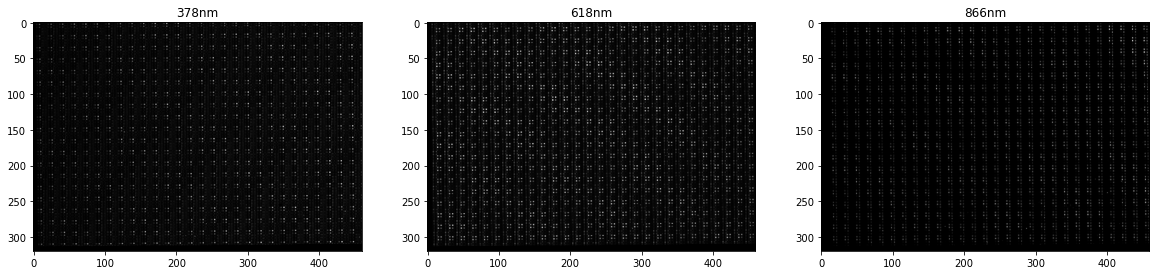

In [7]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

inds = [0,30,60]
for i in range(0,3):
    ax[i].imshow(mask[...,inds[i]], cmap = 'gray')
    ax[i].set_title(str(wavs[inds[i]]) + 'nm')

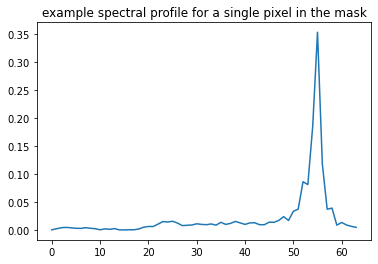

In [8]:
plt.plot(mask[80,80,:]);
plt.title('example spectral profile for a single pixel in the mask');

First, let's run a quick demo to demonstrate how we can use an algorithm called FISTA to recover the full hyperspectral datacube from the 2D measurement. 

FISTA solves the following optimization problem:
$$ \hat{\mathbf{v}} =  \text{argmin}_{\mathbf v \ge 0}\|\mathbf b - A \mathbf v \|_2^2 + \tau P(\mathbf v) $$ 

Here $\hat{\mathbf{v}}$ is our estimated hyperspectral image, $A$ is our imaging forward model (consists of the mask and psf), $\mathbf b$ is our measurement (the variable img in the code), and $P()$ is some prior for our scene. 

FISTA aims to do two things:
* minimize the difference between our measurement and our guess of the image, $\mathbf v$ run through our forward model $A$. This corresponds to the first term $|\mathbf b - A \mathbf v \|_2^2$
* satisfy some scene prior. For instance, a simple prior could be that the image cannot have any negative numbers, so this step would set any value that's less than 0 to be 0 (max($\mathbf {v}$,0)). A better scene prior, such as TV, says that the image gradients are sparse. More info on total variation (TV) can be found here: https://en.wikipedia.org/wiki/Total_variation_denoising

We initialize our estimate of what the image is, $\mathbf{v}_0$ to all zeros (blank), and then use gradient descent to update the estimate of $\mathbf{v}$ based on the above two conditions. In the end, we should have a hyperspectral image that's consistent with our measurement and our estimate of the imaging system, and also is consistent with our chosen scene prior. 

Let's begin!

In [9]:
# Place variables on GPU if using GPU
if device == 'CPU': 
    mask = np.asarray(mask)
    psf = np.asarray(psf)
    img = np.asarray(img)

In [10]:
# Here we define our optimizer, FISTA. If you want to see more of how this works, check out fista_spectral_cupy.py 
fista = fista_spectral_numpy(psf, mask)

In [11]:
# Here we defin some parameters for FISTA. 

fista.iters = 20    # Number of iterations to do

# Default: tv, Options: 'native' for native sparsity, 'non-neg' for enforcing non-negativity only
fista.prox_method = 'tv'  
fista.tv_lambda  = .003
fista.tv_lambdaw = 0.01 


In [12]:
#adjoint testing cell
f = fista.Hfor
adj = fista.Hadj

base_x = np.random.randn(320*2, 460*2, 64)
base_y = np.random.rand(320,460)
x_vector = np.ravel(base_x)
y_vector = np.ravel(base_y)

y_tilde = f(base_x)
y_tilde_vector = np.ravel(y_tilde)
x_tilde = adj(base_y)
x_tilde_vector = np.ravel(x_tilde)

out1 = y_tilde_vector.dot(y_vector)
out2 = x_vector.dot(x_tilde_vector)
print(out1)
print(out2)
print(out1 == out2)

print(fista.DIMS0, fista.DIMS1)
'''
# x and y
base_x = torch.rand((30, 512, 512))
base_y = torch.unsqueeze(torch.rand((2, 256, 256)),0)
x_vector = torch.ravel(base_x)
y_vector = torch.ravel(base_y)
print(y_vector.shape, x_vector.shape)

# y~ = Ax and x~ = A'y
y_tilde = f(base_x.to(device))[0]
x_tilde = f.Hadj(base_y.to(device), f.psf[0][np.newaxis], 1)[0][0]
y_tilde_vector = torch.ravel(y_tilde)


# y' and x~' = (A'y)'
y_transpose = torch.transpose(base_y[0], 1, 2).to(device)
x_tilde_transpose = torch.transpose(x_tilde, 1, 2).to(device)

x_tilde_transpose_vector = torch.ravel(x_tilde_transpose)
y_transpose_vector = torch.ravel(y_transpose)
'''

KeyboardInterrupt: 

In [ ]:
# Run fista! After a few iterations, you should see an image start to emerge
out_img = fista.run(img) 

In [ ]:
out_img = fista.out_img
fc_img = helper.pre_plot(helper.stack_rgb_opt(out_img))

We can show a false color 2D image of the hyperspectral datacube

In [ ]:
plt.imshow(fc_img); plt.axis('off');

Or, we can plot all 64 slices of the datacube and see what they look like.

In [ ]:
helper.plt3D(helper.pre_plot(out_img))

# How to simulate Spectral DiffuerCam and Spectral DefocusCam measurements
Now that you've seen how this works using real data, we can build a simulator that will simulate measurements from our camera. Then, we can use a reconstruction algorithm to recover the original image from the simulated meaurement. 

We can import a hyperspectral image from the Harvard hyperspectral dataset. (http://vision.seas.harvard.edu/hyperspec/download.html)

We already have this dataset downloaded. Feel free to change [idx] to change which image is being loaded in. 

In [13]:
import glob
allFiles = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')

idx = 0
image = scipy.io.loadmat(allFiles[8])['ref']
print(image.shape)

(1040, 1392, 31)


We can plot what this image looks like across spectral channels.  Note that this image is quite large spatially (1040x1391), but only has 31 spectral channels. 

In [14]:
helper.plt3D(image)

interactive(children=(IntSlider(value=1, description='r', max=30), Output()), _dom_classes=('widget-interact',…

In [15]:
# Let's resize the image to be the same as the PSF and mask
image = cv2.resize(image[...,0:30], (psf.shape[1], psf.shape[0]))
print("Resized to:",psf.shape[1],psf.shape[0])

Resized to: 460 320


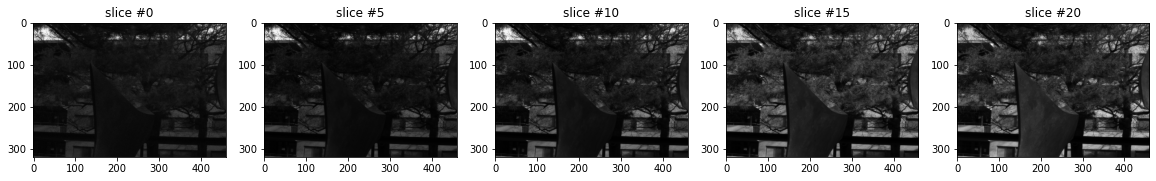

In [16]:
#edited to show a dynamic amount of slices (add index to add slice)
inds = [0,5,10,15,20]
fig, ax = plt.subplots(1,len(inds), figsize = (20,5))


for i in range(0,len(inds)):
    ax[i].imshow(image[...,inds[i]], cmap = 'gray')
    ax[i].set_title('slice #' + str(inds[i]))

Now that we have an example hyperspectral image, we can run the image through our imaging forward model in order to simulate our measurement. 

The forward model for Spectral DiffuserCam is:

$${\bf b} =
\sum\limits_{\lambda = 0}^{K - 1} {{\bf F}_\lambda}[x,y] \cdot
\text{crop}({\bf h}[x,y]\mathop *\limits^{[x,y]} {\bf
v}[x,y,\lambda]) $$

What this means, is that we have a convolution between the scene (v) and the PSF (h), then a point-wise multiplication with the filter function (mask). 

By the convolution theorem (https://en.wikipedia.org/wiki/Convolution_theorem), a convolution is a muliplication in fourier space:

$$ x \mathop * y = {F^{-1}}({F}(x) \cdot {F}(y)) $$

Note: Convolution in 2D space is O(n^2), while FFT allows us to take fourier transforms in nlog(n).

So, our forward model becomes:
$${\bf b} =
\sum\limits_{\lambda = 0}^{K - 1} {{\bf F}_\lambda}[x,y] \cdot
\text{crop}(F^{-1} (F({\bf h}[x,y]) \cdot F({\bf
v}[x,y,\lambda]))) $$

We must first zero pad both our measurement and our PSF, then we can take the FFT. Below are two functions we can use for zero-padding and cropping.

In [17]:
py = int((psf.shape[0])//2)    # Pad size
px = int((psf.shape[1])//2)    # Pad size

def pad(x):
    if len(x.shape) == 2: 
        out = np.pad(x, ([py, py], [px,px]), mode = 'constant')
    elif len(x.shape) == 3:
        out = np.pad(x, ([py, py], [px,px], [0, 0]), mode = 'constant')
    return out

def crop(x):
    return x[py:-py, px:-px]

In [18]:
# put the image on GPU if using
if device == 'GPU': 
    image = np.asarray(image)

In [19]:
# Pad the image and PSF
psf_padded = pad(psf)
img_padded = pad(image)

Text(0.5, 1.0, 'padded hyperspectral image (20th slice)')

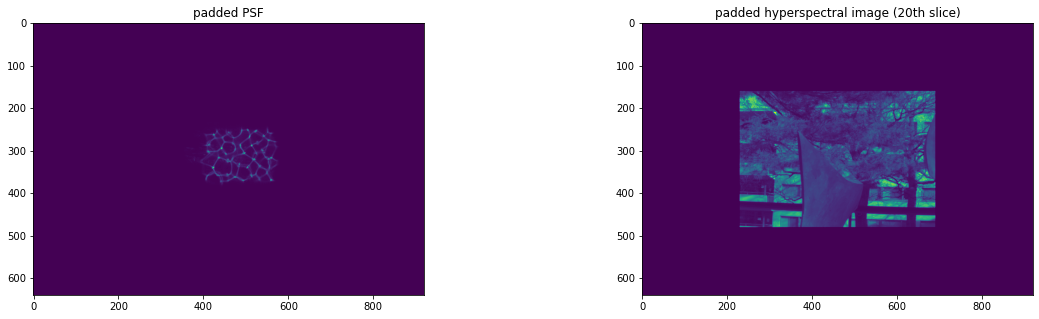

In [20]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].imshow(psf_padded)
ax[1].imshow(img_padded[...,20])

ax[0].set_title('padded PSF')
ax[1].set_title('padded hyperspectral image (20th slice)')

Now, we can take the fourier transform of both:

Text(0.5, 1.0, 'FFT(image), 20th slice')

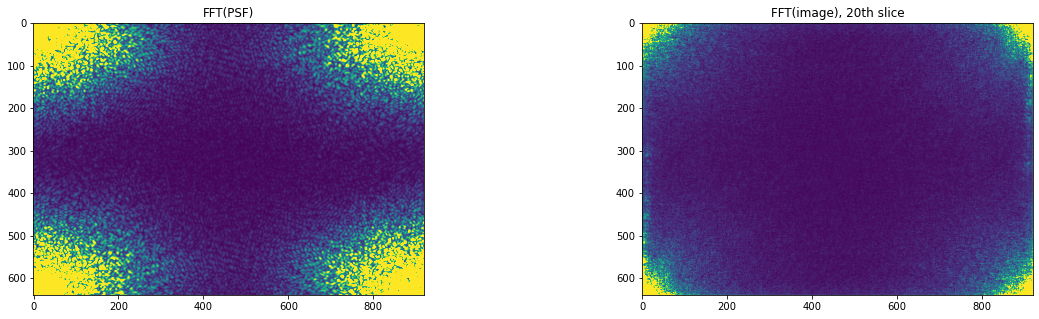

In [21]:
H = np.expand_dims(np.fft.fft2((np.fft.ifftshift(psf_padded, axes = (0,1))), axes = (0,1)), -1)
Im = np.fft.fft2(img_padded, axes = (0,1))

fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].imshow(np.abs(H), vmin = 0, vmax = 1)
ax[1].imshow(np.abs(Im[...,20]), vmin = 0, vmax = 10)

ax[0].set_title('FFT(PSF)')
ax[1].set_title('FFT(image), 20th slice')

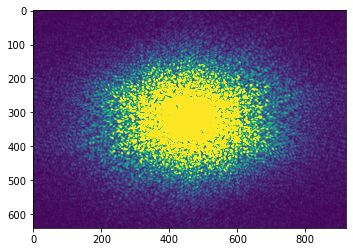

In [22]:
plt.imshow(np.abs(np.fft.fftshift(H, axes = (0,1))), vmin = 0, vmax = 1)


Now, we can multiply both together and take the IFFT. This is what the image would look like if we didn't have the spectral filter array and only had the diffuser in front of a sensor. 

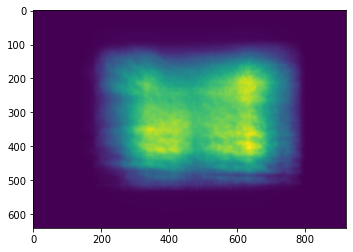

In [23]:
him = np.fft.ifft2(H*Im, axes = (0,1))
plt.imshow(np.abs(him[...,20]))

Finally, we can multiply by the mask function, crop, and then sum across wavelengths. Note, we use 30 out of the 64 mask channels in order to match the number of spectral channels in the dataset. 

In [24]:
print(mask.shape)

(320, 460, 64)


In [25]:
mask_condensed = (mask[...,0::2] + mask[...,1::2])[...,0:30]/2
for i in range(0,30):
    mask_condensed[...,i] = mask_condensed[...,i]/np.linalg.norm(mask_condensed[...,i])
mask_condensed = mask_condensed/np.max(mask_condensed)


Text(0.5, 1.0, 'Final simulated image (sum across all wavelenghs)')

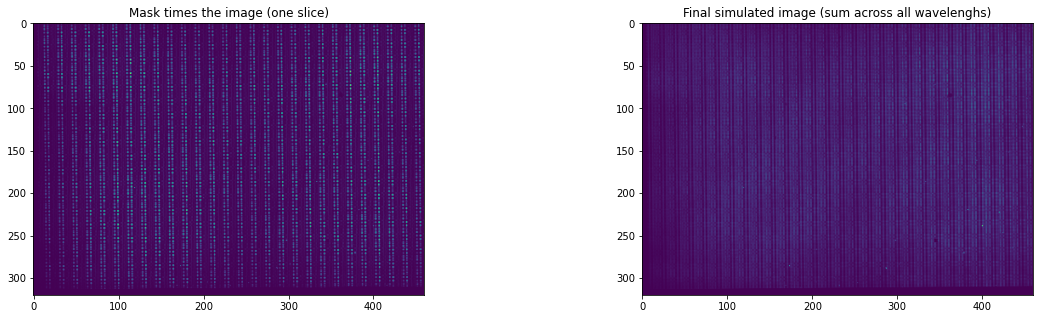

In [26]:
mask_image = mask_condensed* crop(np.real(him))
final_simulated_image = np.sum(mask_image, 2)

fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].imshow(mask_image[...,10])
ax[1].imshow(final_simulated_image)

ax[0].set_title('Mask times the image (one slice)')
ax[1].set_title('Final simulated image (sum across all wavelenghs)')

## Putting it all together as a single function
Note: this is what is used in FISTA as the forward model. Check it out in fista_spectral_cupy.py 

In [30]:
def Hfor(x, psf, mask):
    H = np.expand_dims(np.fft.fft2((np.fft.ifftshift(pad(psf), axes = (0,1))), axes = (0,1)), -1) 
    x = np.fft.ifft2(H* np.fft.fft2(pad(x), axes = (0,1)), axes = (0,1))
    x = np.sum(mask* crop(np.real(x)), 2)
    return x

In [31]:
final_simulated_image = Hfor(image, psf, mask_condensed)

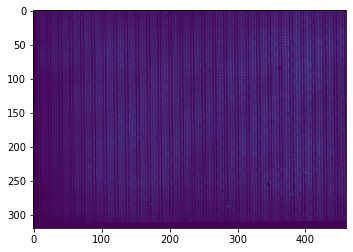

In [32]:
plt.imshow(final_simulated_image)

## Quick aside, why do we need to pad and crop?
Below is the same forward model without the pad and the crop. What's happening here? 

In [30]:
def Hfor_bad(x, psf, mask):
    H = np.expand_dims(np.fft.fft2((np.fft.ifftshift(psf, axes = (0,1))), axes = (0,1)), -1) 
    x = np.fft.ifft2(H* np.fft.fft2(x, axes = (0,1)), axes = (0,1))
    x = np.sum(mask* np.real(x), 2)
    return x

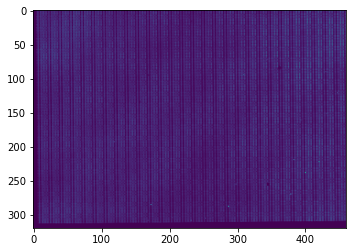

In [31]:
final_simulated_image_bad = Hfor_bad(image, psf, mask_condensed)
plt.imshow(final_simulated_image_bad)

## Running FISTA on the simulated image

In [33]:
fista_sim = fista_spectral_numpy(psf, mask_condensed)

In [34]:
out_img = fista_sim.run(final_simulated_image)

KeyboardInterrupt: 

How did we do? We can compare the result against the ground truth hyperspectral image.

In [ ]:
out_img = fista_sim.out_img
helper.plt3D(out_img)

Here's the original image:

In [ ]:
helper.plt3D(image)

## Moving from Spectral DiffuserCam to Spectral DefocusCam 

Now, rather than having a diffuser, we want to simulate the forward model of our camera with a sharp and a blurry lens. 

We can approximate the lens blur as a convolution with a gaussian instead of a convolution with a diffuser. Therefore, we can use the same forward model - we only need to change the PSF. 

Text(0.5, 1.0, 'Sharp PSF')

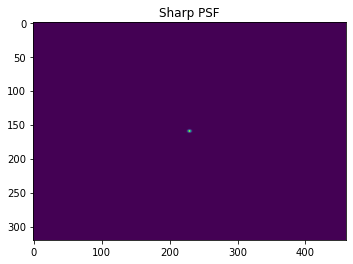

In [37]:
x=np.linspace(-1,1,psf.shape[1])
y=np.linspace(-1,1,psf.shape[0])
X,Y=np.meshgrid(x,y)
wx=0.01 # Change these to update the width of the gaussian
wy=0.01
psf_sharp= np.exp(-((X/wx)**2+(Y/wy)**2))
psf_sharp=psf_sharp/np.linalg.norm(psf_sharp)
plt.figure()
plt.imshow(psf_sharp)#.get())
plt.title('Sharp PSF')

Now we can use the sharp PSF to simulate our meausrement. Notice that the image looks sharp, but holey.

(-0.5, 459.5, 319.5, -0.5)

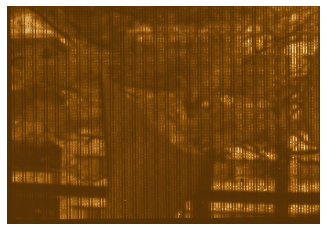

In [38]:
simualted_sharp = Hfor(image, psf_sharp, mask_condensed)
k = 30
plt.imshow(simualted_sharp, cmap = 'BrBG')
plt.axis('off')
#plt.title('simulated measurement with sharp lens')
#plt.imshow(helper.stack_rgb_opt(simualted_sharp, scaling = [0.48*k,0.827*k,2.02*k]))

We can try to recover the full hyperspectral volume using this meaurement as a baseline to see how well we can do with FISTA (using the single image taken with a sharp lens).

iteration:  0  loss:  557.4674876964312


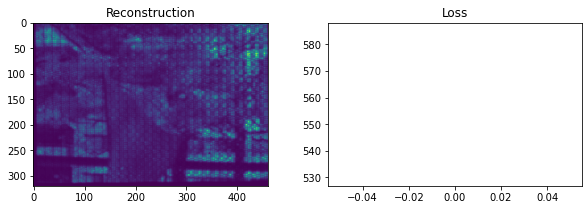

iteration:  20  loss:  229.68298390136485


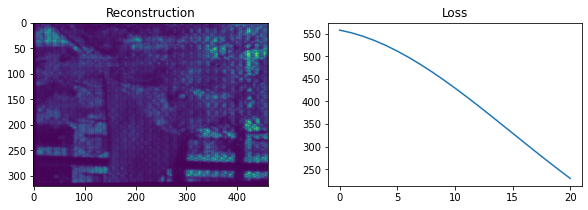

iteration:  40  loss:  21.330075039144592


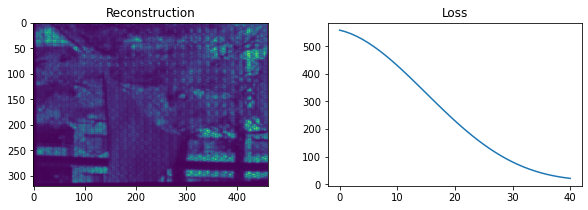

iteration:  60  loss:  14.859503726102263


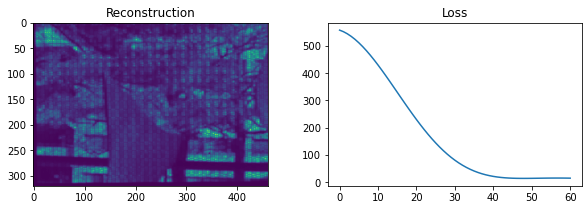

KeyboardInterrupt: 

In [39]:
fista_sharp = fista_spectral_numpy(psf_sharp, mask_condensed)
fista_sharp.tv_lambda  = .003
fista_sharp.tv_lambdaw = 0.01 

out_img = fista_sharp.run(simualted_sharp)

Notice how there are holes in the reconstuction. TV tries to fill them in as best as possible, but some information is missing. A better prior could perhaps help with this. 

In [45]:
out_img = fista_sharp.out_img
helper.plt3D(out_img)

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

Now we can simulate a blurry lens by changing the width of the gaussian.

Text(0.5, 1.0, 'Blurry PSF')

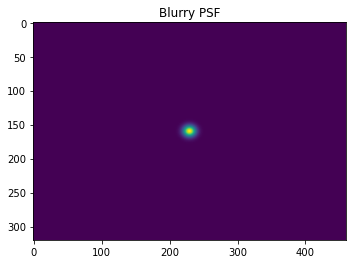

In [46]:
x=np.linspace(-1,1,psf.shape[1])
y=np.linspace(-1,1,psf.shape[0])
X,Y=np.meshgrid(x,y)
wx=0.04
wy=0.05
psf_blurry= np.exp(-((X/wx)**2+(Y/wy)**2))
psf_blurry=psf_blurry/np.linalg.norm(psf_blurry)
plt.figure()
plt.imshow(psf_blurry)#.get())
plt.title('Blurry PSF')

#plt.plot(psf_blurry.get()[psf.shape[0]//2])

(-0.5, 459.5, 319.5, -0.5)

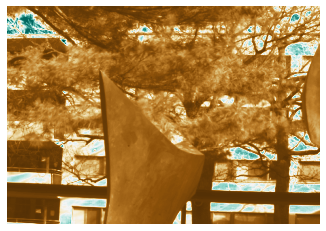

In [47]:
simualted_blurry = Hfor(image, psf_blurry, mask_condensed)

plt.imshow(np.mean(image, -1), cmap = 'BrBG')
plt.axis('off')
#plt.title('simulated measurement with blurry lens')

Now the measurement is blurred out. As before, we can try to recover the volume using FISTA.

iteration:  0  loss:  9276.42046159419


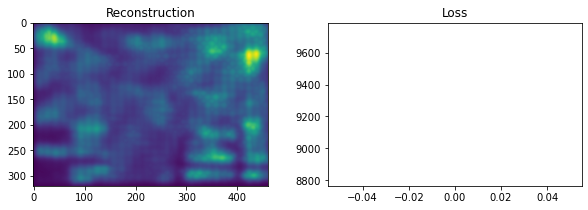

KeyboardInterrupt: 

In [52]:
fista_blurry = fista_spectral_numpy(psf_blurry, mask_condensed)
fista_blurry.tv_lambda  = .003
fista_blurry.tv_lambdaw = 0.01 

out_img = fista_blurry.run(simualted_blurry)

In [48]:
out_img = fista_blurry.out_img
helper.plt3D(out_img)

NameError: name 'fista_blurry' is not defined

In [42]:
out_img = fista_sharp.out_img
helper.plt3D(image.get())

AttributeError: 'numpy.ndarray' object has no attribute 'get'

We can compare the result to the ground truth with the ground truth blurred 16X (this is approximately the size of 1 super pixel). The blurred reconstruction looks pretty similar to this.

In [49]:
imt = cv2.blur(image.get(),(16,16))

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [31]:
helper.plt3D(imt)

NameError: name 'imt' is not defined

## Spectral DefocusCam - combining a sharp and blurry image

Now let's see what happens when we feed both the sharp and the blurry measurement into FISTA, and use both images to solve for a single hyperspectral volume. To do this, we need to modify FISTA to take in two PSFs as well as two images. Now, the gradient updates based on the average of both measurement, instead of only one or the other.

In [50]:
img_comb = np.stack((simualted_blurry, simualted_sharp), 0)


In [51]:
psf_stack = np.stack((psf_blurry, psf_sharp), 0)


In [53]:
%run fista_spectral_cupy_batch.py CPU

device =  CPU , using CPU and numpy


In [59]:
import PIL.Image as Image
import os
import psf_calibration_utils as psf_utils
psfs = psf_utils.get_psf_stack("../defocuscamdata/calibration_data/psfs2")
psf_stack = psf_utils.center_pad_to_shape(psfs, mask.shape[:2], val = 0)
psf_stack = np.array(psf_stack)

meas_dir = "../defocuscamdata/test_measurements/test_measurements_2/"
measurements = ["dog_focused_300", "dog_blurry_1_300", "dog_blurry_2_300"]
measurement_stack = np.stack([np.array(Image.open(os.path.join(meas_dir,meas +".png.png"))) for meas in measurements], 0)
measurement_stack = measurement_stack[:,100:100+psf_stack.shape[-2],100:100+psf_stack.shape[-1]]

In [60]:
# This fista function can take in multiple images at once. Feel free to modify this to take in 2+ images. 
# You can also vary the amount of blur to see what works best

fista_comb = fista_spectral_numpy(psf_stack, mask_condensed)
fista_comb.tv_lambda  = .003
fista_comb.tv_lambdaw = 0.01 

In [61]:
print(psf_stack.shape, mask_condensed.shape)
print(psf_stack.dtype)

(3, 320, 460) (320, 460, 30)
float64


In [62]:
out_img = fista_comb.run(measurement_stack)

AttributeError: 'numpy.float64' object has no attribute 'get'

In [57]:
out_img = fista_comb.run(img_comb)

KeyboardInterrupt: 

In [ ]:
out_img = fista_comb.out_img
helper.plt3D(out_img)

We can compare each of the results (diffusercam, sharp lens, blurry lens, and combined sharp + blurry lens) to see which one performs better. Below we can plot a few slices from the hyperspectral volume

In [ ]:
inds = [5,10,15,20,25,29]

fig, ax = plt.subplots(len(inds),5, figsize= (20,20))

titles = ['diffusercam', 'sharp lens', 'blurry lens', 'combined (sharp + blurry)', 'ground truth']
for i in range(0,len(inds)):
    ax[i,0].imshow(fista_sim.out_img[...,inds[i]])
    ax[i,1].imshow(fista_sharp.out_img[...,inds[i]])
    ax[i,2].imshow(fista_blurry.out_img[...,inds[i]])
    ax[i,3].imshow(fista_comb.out_img[...,inds[i]])
    ax[i,4].imshow(image.get()[...,inds[i]])
   
for j in range(0,5):
    ax[0,j].set_title(titles[j])
for i in range(0,len(inds)):
    for j in range(0,5):
        ax[i,j].axis('off')

In [ ]:
plt.imshow(fista_comb.out_img[...,inds[i]])

Instead of looking at wavelength slices, we can also look at the spectral profile for individual points in the image and compare them to the ground truth spectral profile.

In [ ]:
# specify the y and x coordinates below
inds1 = [50,100,200,280,250,150]
inds2 = [100,300,120,380,200,290]

fig, ax = plt.subplots(len(inds),1, figsize= (20,10))

titles = ['diffusercam', 'sharp lens', 'blurry lens', 'combined (sharp + blurry)', 'ground truth']
for i in range(0,len(inds)):
    ax[i].plot(fista_sim.out_img[inds1[i], inds[2]])
    ax[i].plot(fista_sharp.out_img[inds1[i], inds[2]])
    ax[i].plot(fista_blurry.out_img[inds1[i], inds[2]])
    ax[i].plot(fista_comb.out_img[inds1[i], inds[2]])
    ax[i].plot(image.get()[inds1[i], inds[2]])

ax[0].legend(titles)

We can also compute several metrics (like MSE, SSIM, PSNR, cosine similarity (particularly useful for hyperspectral imaging), and LPIPS (perceptual similarity metric) to compare how well the reconstruction did against the ground truth. Here, we use these metrics to compare the performance. In machine learning, some of these metrics can be used as the loss function and will be integral to training the network.

In [ ]:
def cal_mse(im1, im2):
    im1 = im1/numpy.linalg.norm(im1) #normalize both matrices
    im2 = im2/numpy.linalg.norm(im2)
    return numpy.sum(numpy.abs(im1 -im2)**2) #for each element pairwise: sum over i,j |Xij - Yij|

In [ ]:
print('Diffuser', cal_mse(fista_sim.out_img, image.get()))
print('Sharp Lens',cal_mse(fista_sharp.out_img, image.get()))
print('Blurry Lens',cal_mse(fista_blurry.out_img, image.get()))
print('Sharp + Blurry Lens',cal_mse(fista_comb.out_img, image.get()))

In [ ]:
print('Sharp + Blurry Lens',cal_mse(fista_comb.out_img, image.get()))